<a href="https://colab.research.google.com/github/salvaderron/Artificial-Neural-Network_and_Deep-Learning/blob/main/ANN_%26_DL_Lab_9_(GNN_Node_Classification)_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Load Karate Club graph and prepare labels
G = nx.karate_club_graph()
club_map = {'Mr. Hi': 0, 'Officer': 1}
y = np.array([club_map[G.nodes[n]['club']] for n in G.nodes()], dtype=np.int32)

# 2. Build & normalize adjacency matrix
A = nx.to_numpy_array(G)
N = A.shape[0]
A_hat = A + np.eye(N)
D_inv_sqrt = np.diag(1.0 / np.sqrt(A_hat.sum(1)))
A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt  # shape (N, N)

# 3. Node features = identity (one‐hot per node)
X = np.eye(N, dtype=np.float32)           # shape (N, N)

# 4. Train/test split on nodes
idx = np.arange(N)
train_idx, test_idx = train_test_split(idx, stratify=y, test_size=0.5, random_state=42)
train_mask = np.zeros(N, bool); train_mask[train_idx] = True
test_mask  = np.zeros(N, bool); test_mask[test_idx]  = True

# … (everything up through A_norm and X as before) …

# 5. Custom GCN layer (unchanged)
class GCNLayer(layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = layers.Activation(activation) if activation else None

    def build(self, input_shape):
        F_in = input_shape[-1]
        self.w = self.add_weight(
            shape=(F_in, self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.A_norm = tf.constant(A_norm, dtype=tf.float32)
        super().build(input_shape)

    def call(self, X):
        x = tf.matmul(self.A_norm, X)
        x = tf.matmul(x, self.w)
        if self.activation:
            x = self.activation(x)
        return x

# 6. Build the 2‐layer GCN model, now taking the full (N,N) matrix
inputs = layers.Input(shape=(N, N), name='X')     # one sample → shape (1, N, N)
h = GCNLayer(16, activation='relu')(inputs)       # → (1, N, 16)
h = layers.Dropout(0.5)(h)
out = GCNLayer(2, activation='softmax')(h)         # → (1, N, 2)

model = Model(inputs=inputs, outputs=out)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    weighted_metrics=['accuracy']
)

# 7. Prepare single‐sample batches
X_batch = X[np.newaxis, ...]                      # shape (1, N, N)
y_batch = y.reshape((1, N))                       # shape (1, N)
sw_batch = train_mask.astype('float32').reshape((1, N))

# 8. Train
model.fit(
    x=X_batch,
    y=y_batch,
    sample_weight=sw_batch,
    epochs=200,
    verbose=0
)

# 9. Predict
y_pred_prob = model.predict(X_batch)[0]           # → shape (N, 2)
y_pred = y_pred_prob.argmax(axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Train Accuracy: 0.9412
Test  Accuracy: 1.0000


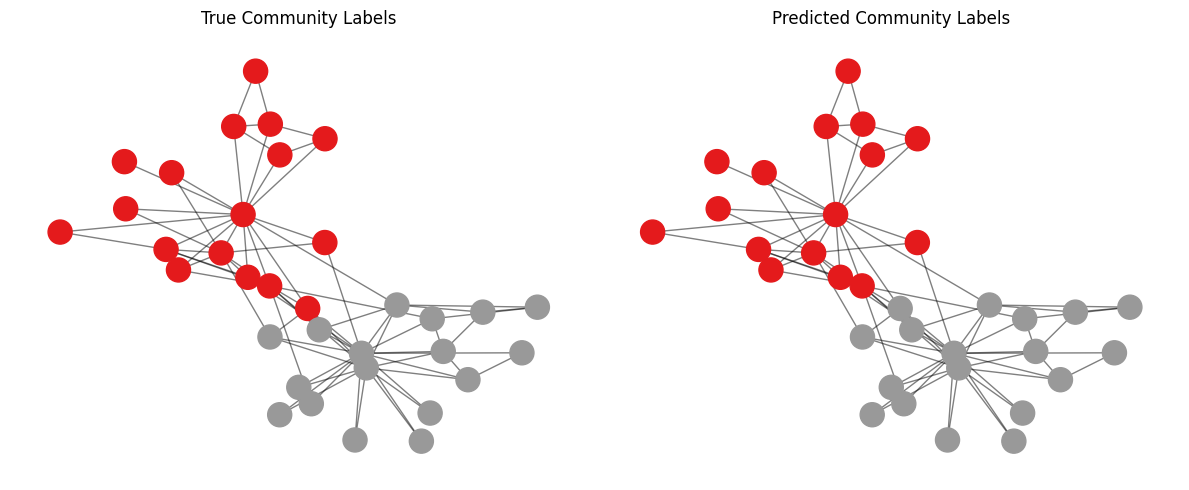

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# --- After training & prediction ---

# Assume you have:
#   X_batch: shape (1, N, N)
#   y_batch: shape (1, N)
#   sw_batch: shape (1, N)
#   model: your compiled & trained Keras model
#   train_mask: boolean array of length N
#   test_mask:  boolean array of length N
#   G: the NetworkX graph

# 1. Predict on the single-graph batch
y_pred_prob = model.predict(X_batch, verbose=0)[0]   # (N, 2)
y_pred = y_pred_prob.argmax(axis=1)                 # (N,)

# 2. Compute accuracy on train and test nodes
y_true = y_batch[0]                                  # (N,)
train_acc = np.mean(y_pred[train_mask] == y_true[train_mask])
test_acc  = np.mean(y_pred[test_mask]  == y_true[test_mask])
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}")

# 3. Visualization of true vs. predicted labels
pos = nx.spring_layout(G, seed=42)  # fixed layout

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, labels, title in zip(
    axes,
    [y_true, y_pred],
    ['True Community Labels', 'Predicted Community Labels']
):
    nx.draw_networkx_nodes(
        G, pos,
        node_color=labels,
        cmap='Set1',
        node_size=300,
        ax=ax
    )
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
